In [4]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from scipy import stats
import tensorflow as tf

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load the data

In [10]:
df_s.shape

(36238, 2)

In [13]:
df_s

,ACILIS_TARIHI,value
0,2019-10-06 12:30:00,1
1,2019-10-06 12:45:00,0
2,2019-10-06 13:00:00,0
3,2019-10-06 13:15:00,0
4,2019-10-06 13:30:00,0
...,...,...
36233,2020-10-17 22:45:00,3
36234,2020-10-17 23:00:00,2
36235,2020-10-17 23:15:00,0
36236,2020-10-17 23:30:00,1


In [19]:
df_s.set_index("ACILIS_TARIHI",inplace=True)

In [22]:
n=df_s.count().sum()

In [11]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36238 entries, 0 to 36237
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ACILIS_TARIHI  36238 non-null  object
 1   value          36238 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 566.3+ KB


In [ ]:
df_s["value"].mean()

In [ ]:
s_array

In [ ]:
s_array = df_s["value"].to_numpy() 

In [ ]:
stats.zscore(s_array)

In [ ]:
s_zscore = stats.zscore(s_array)

In [ ]:
stats.zscore(s_array).mean()

In [ ]:
s_array.std()

In [ ]:
math.sqrt(n)

In [ ]:
s_mean = s_array.mean()
s_std = s_array.std()
s_sqrt = math.sqrt(n)

In [ ]:
print(s_mean + s_zscore*(s_std/s_sqrt))
print(s_mean - s_zscore*(s_std/s_sqrt))

In [ ]:
 my_array = s_mean + s_zscore*(s_std/s_sqrt)

#Visualize the data

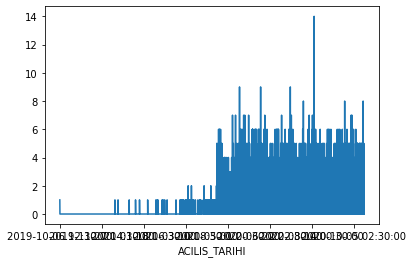

In [24]:
fig, ax = plt.subplots()
df_s.plot(legend=False, ax=ax)
plt.show()

Box plot visualization:


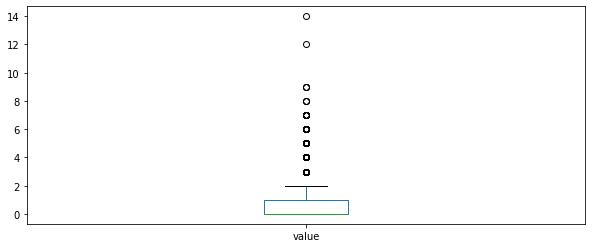

In [26]:
print('Box plot visualization:')
df_s.plot(kind='box', figsize = (10,4))
plt.show()

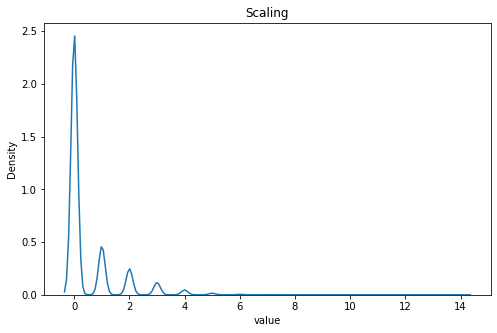

In [28]:
import seaborn as sns
fig,ax1=plt.subplots(ncols=1,figsize=(8,5))
ax1.set_title("Scaling")
sns.kdeplot(df_s["value"],ax=ax1)
plt.show()

#Prepare training data

In [30]:
training_mean = df_s.mean()
training_std = df_s.std()
df_training_value = (df_s - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 36238


Create sequences

In [32]:
# helper function
TIME_STEPS =48

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (36190, 48, 1)


#Build a model

In [35]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 32)            256       
_________________________________________________________________
dropout (Dropout)            (None, 24, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 24, 16)            1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 16)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 48, 32)            3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 48, 1)             2

#Train the model

In [37]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
255/255 [==============================] - 7s 22ms/step - loss: 0.4008 - val_loss: 0.0738
Epoch 2/50
255/255 [==============================] - 5s 21ms/step - loss: 0.0741 - val_loss: 0.0372
Epoch 3/50
255/255 [==============================] - 5s 21ms/step - loss: 0.0543 - val_loss: 0.0430
Epoch 4/50
255/255 [==============================] - 5s 21ms/step - loss: 0.0445 - val_loss: 0.0402
Epoch 5/50
255/255 [==============================] - 5s 21ms/step - loss: 0.0382 - val_loss: 0.0415
Epoch 6/50
255/255 [==============================] - 5s 22ms/step - loss: 0.0327 - val_loss: 0.0628
Epoch 7/50
255/255 [==============================] - 5s 21ms/step - loss: 0.0289 - val_loss: 0.0701


#Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct the input data.

Find MAE loss on training samples.
Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

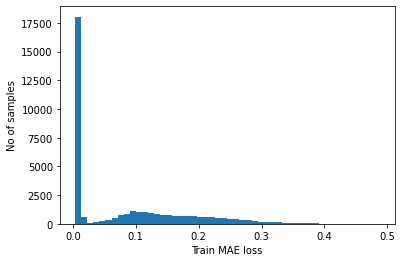

Reconstruction error threshold:  0.48756151236187173


In [38]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

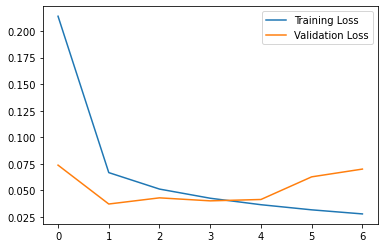

In [39]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

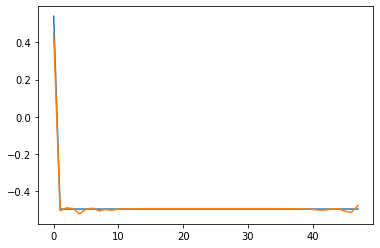

In [40]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
# Detect all the samples which are anomalies.
#anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
df_s["Outliers"]=pd.Series(model.predict(df_s[["value"]])).apply(lambda x: "yes" if( x==1) else "no")

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)